In [1]:
# Advertising Simulator
# This program simulates the advertising of a product over a period of time.
# It will simulate the number of people who have seen the product advertising, brand experience, and product experience.

import numpy as np
import pandas as pd 
import math
import seaborn as sns

def sigmoid(x):
    return 1 / (1 + math.exp(-x))


class customer:
    def __init__(self):
        # Awareness
        self.advertising_exposure = {}
        # Interest
        # Attitude towards advertising
        self.attitude_towards_advertising = {}
        # Desire
        self.attitude_towards_brand = {}
        # Action: Purchase decision
        self.brand_experience = {}
        self.budget = np.random.randint(1000, 5000)
        self.likelihood_of_purchase = {}
        
    def couch_time(self, brand_name, campaign_name):
        # Advertising Exposure
        if campaign_name not in self.advertising_exposure:
            self.advertising_exposure[campaign_name] = 1
        else:
            self.advertising_exposure[campaign_name] += 1
        
        # Attitude towards advertising
        if campaign_name not in self.attitude_towards_advertising:
            self.attitude_towards_advertising[campaign_name] = 1
        else:
            if self.attitude_towards_advertising[campaign_name] <= 100:
                self.attitude_towards_advertising[campaign_name] += np.log(self.advertising_exposure[campaign_name]+ 1)
        
        # Attitude towards brand
        if brand_name not in self.attitude_towards_brand:
            self.attitude_towards_brand[brand_name] = 1
        else:
            if self.attitude_towards_brand[brand_name] <= 100:
                self.attitude_towards_brand[brand_name] += np.log(self.attitude_towards_advertising[campaign_name]+ 1)


    def purchase(self, brand_name, item_price, brand_sales):
        # Random seed assignment
        np.random.seed(0)
        # Purchase decision
        # Purchase decision is binary variable, 1 for purchase and 0 for no purchase
        # If there is a previous brand experience, the probability of purchase will be higher than brand without experience
        if brand_name not in self.brand_experience:
            self.brand_experience[brand_name] = 0

        # Get the likelihood of purchase which will be used for binomial distribution.
        # Sigmoid function to get the probability of purchase to bound in range between 0 and 1
        likelihood_of_purchase = np.log((self.attitude_towards_brand[brand_name]) / sum(self.attitude_towards_brand.values()) + 1) * np.log(self.brand_experience[brand_name]+1)
        likelihood_of_purchase = sigmoid(likelihood_of_purchase)
        
        # if brand_name not in self.likelihood_of_purchase:
        if brand_name not in self.likelihood_of_purchase:
            self.likelihood_of_purchase[brand_name] = []
        # append the likelihood of purchase to the list
        self.likelihood_of_purchase[brand_name].append(likelihood_of_purchase)
        

        # Purchase decision
        status = np.random.binomial(1, likelihood_of_purchase)
        if status == 1 and self.budget > item_price:
            self.brand_experience[brand_name] += 1
            brand_sales += item_price
            return brand_sales
        else:
            # print("Not enough money to purchase the item.")
            self.budget += np.random.randint(100, 500)
            return brand_sales
                   
    def __str__(self):
        return "Attitude towards brand: " + str(self.attitude_towards_brand) + ", Attitude towards advertising: " + str(self.attitude_towards_advertising) + ", Advertising Exposure: " + str(self.advertising_exposure)
              

class brand:
    def __init__(self, brand_name, brand_budget, brand_power, item_price):
        self.brand_name = brand_name
        self.advertising_spending = 0
        self.advertising_budget = brand_budget
        self.brand_power = brand_power
        self.campaign = {}
        self.item_price = item_price
        self.brand_sales = 0
        campaign_name_lst = [self.brand_name + " Campaign " + str(i) for i in range(np.random.randint(3, 10))]
        for ad_campaign in campaign_name_lst:
            self.campaign[ad_campaign] = {}
            self.campaign[ad_campaign]["expense"] = np.random.normal(3,1)
            self.campaign[ad_campaign]["exposure"] = 0
            # self.campaign[ad_campaign]["total_expense"] += self.campaign[ad_campaign]["expense"]


    def advertise(self, customer):
        ad_campaign = np.random.choice([element for element in self.campaign.keys()])
        if self.advertising_budget > self.campaign[ad_campaign]["expense"]:
            self.advertising_budget -= self.campaign[ad_campaign]["expense"]
            self.advertising_spending += self.campaign[ad_campaign]["expense"]
            self.campaign[ad_campaign]["exposure"] += 1
            customer.couch_time(self.brand_name, ad_campaign)
            self.brand_sales = customer.purchase(self.brand_name, self.item_price, self.brand_sales)
        else:
            print("No budget left for advertising")
            self.brand_sales = customer.purchase(self.brand_name, self.item_price, self.brand_sales)





In [2]:
# Customer objects
customers = [customer() for i in range(1000)]

# Brand objects
brands = [brand("Coca-Cola", 1000000, 100, 1.79), 
          brand("Pepsi", 1000000, 100, 1.79), 
          brand("Dr. Pepper", 1000000, 100, 1.89), 
          brand("Sprite", 1000000, 100, 1.89),
          brand("Starbucks", 1000000, 100, 3.19)
          ]


ads_effects = []
# Expose advertisings
for n in range(100000):
    np.random.seed(n)
    i = np.random.choice(range(len(customers)))
    j = np.random.choice(range(len(brands)))
    brands[j].advertise(customers[i])
    ads_effects.append([i, 
                        j, 
                        customers[i].advertising_exposure, 
                        customers[i].attitude_towards_advertising, 
                        customers[i].attitude_towards_brand, 
                        customers[i].brand_experience, 
                        customers[i].budget,
                        customers[i].likelihood_of_purchase,
                        brands[j].advertising_spending, 
                        brands[j].brand_sales,
                        brands[j].item_price,
                        brands[j].campaign])
                        

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4804530139182014
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4804530139182014
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4804530139182014
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4804530139182014
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4804530139182014
0.0
0.4804530139182014
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4804530139182014
0.0
0.0
0.0

In [3]:
df = pd.DataFrame(ads_effects, columns = ["Customer", 
                                          "Brand", 
                                          "Advertising Exposure", 
                                          "Attitude towards Advertising", 
                                          "Attitude towards Brand", 
                                          "Brand Experience", 
                                          "Budget",
                                          "Likelihood of Purchase",
                                          "Advertising Spending",
                                          "Brand Sales",
                                          "Item Price",
                                          "Campaign"] )

tmp = df[['id', 'Brand', 'Likelihood of Purchase']]
temp = pd.concat([tmp[["id", "brand"]], tmp["likelihood of purchase"].apply(pd.Series)], axis = 1)
temp = temp.drop_duplicates(["Customer", "Brand"], keep = "last")

unique_id = temp["id"].unique()[:100]
for id in unique_id:
    for brand in temp["Brand"].unique():
        tmp1 = temp[(temp["id"] == id)].reset_index(drop = True).reset_index(drop = False)
    #print(tmp1.shape)
    sns.lineplot(x="index", y="Likelihood of Purchase", data=tmp1)

NameError: name 'temp' is not defined

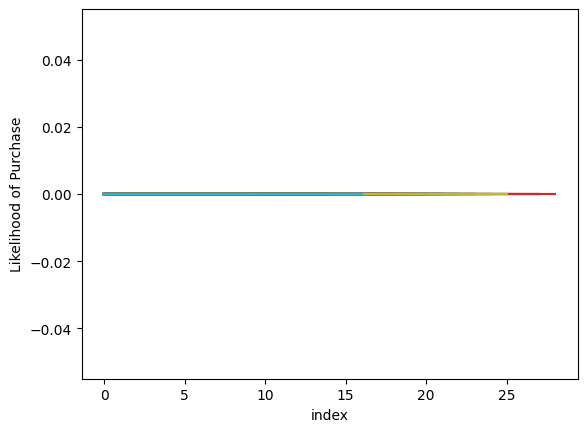

In [ ]:
unique_id = temp["id"].unique()[:100]
for id in unique_id:
    tmp1 = temp[(temp["id"] == id) & (temp["variable"] == "Coca-Cola")].reset_index(drop = True).reset_index(drop = False)
    #print(tmp1.shape)
    sns.lineplot(x="index", y="Likelihood of Purchase", data=tmp1)

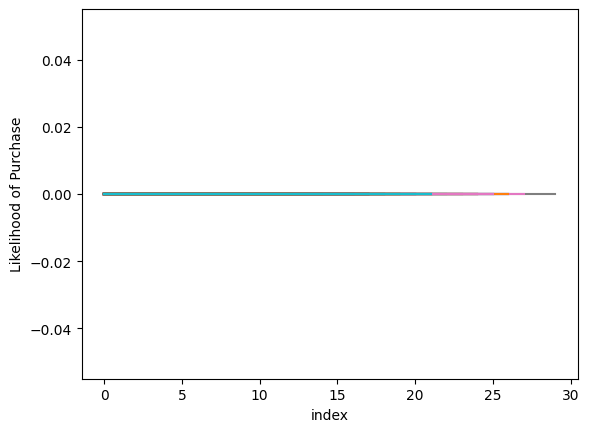

In [ ]:
unique_id = temp["id"].unique()[:100]
for id in unique_id:
    tmp1 = temp[(temp["id"] == id) & (temp["variable"] == "Pepsi")].reset_index(drop = True).reset_index(drop = False)
    #print(tmp1.shape)
    sns.lineplot(x="index", y="Likelihood of Purchase", data=tmp1)

In [ ]:
customers[0].likelihood_of_purchase["Coca-Cola"]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]